# Pip Install Requirements

In [1]:
# !pip3 install keras
# !pip3 install tensorflow
# !pip3 install keras
# !pip3 install numpy
# !pip3 install sklearn
# !pip3 install pandas
# !pip3 install opencv-python

# Imports

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#Choices
num_features = 64
num_classes = 7
batch_size = 64
epochs = 50
width, height = 48, 48
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
#Read data
df = pd.read_csv('./fer2013.csv')

# Data Exploration

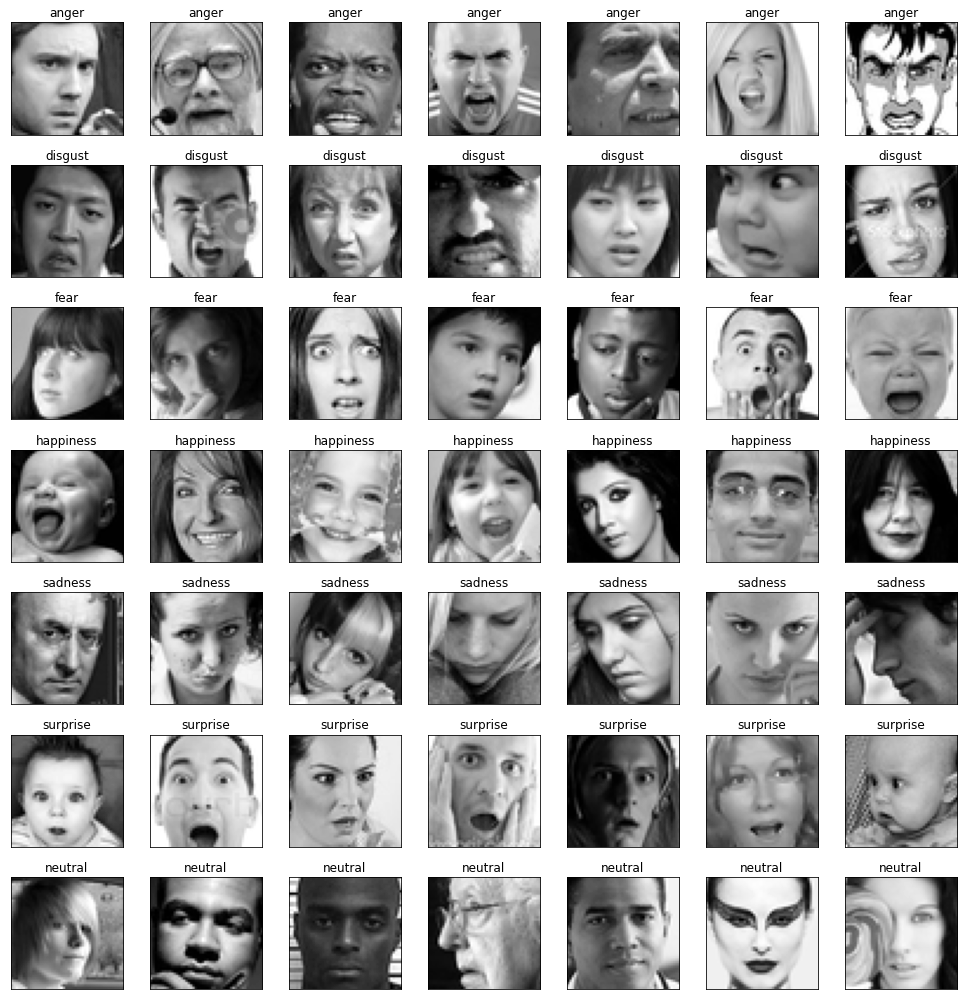

In [3]:
# Plotted a part of the data
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(num_classes):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

## Plotting the data

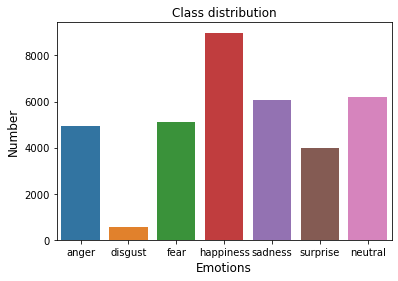

In [4]:
# Plotting a bar graph of the class distributions
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_label_to_text)

plt.figure(figsize=(6,4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

To note: quite a difference between happiness and the other ones. Furthermore, disgust is really not present.

## Data split

In [5]:
from tensorflow.keras.utils import to_categorical

# Preprocessing and data split
train_set = df[(df.Usage == 'Training')]
val_set = df[(df.Usage == 'PublicTest')]
test_set = df[(df.Usage == 'PrivateTest')]
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32)
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32)
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32)
X_train = X_train.reshape(X_train.shape[0], width, height, 1) / 255
X_val = X_val.reshape(X_val.shape[0], width, height, 1) / 255
X_test = X_test.reshape(X_test.shape[0], width, height, 1) / 255

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

y_train = train_set.emotion
y_train = to_categorical(y_train, num_classes)
y_val = val_set.emotion
y_val = to_categorical(y_val, num_classes)
y_test = test_set.emotion
y_test = to_categorical(y_test, num_classes)

## Build Model (details in the report)

In [22]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D , BatchNormalization, MaxPooling2D
from keras import Sequential
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam

# create model
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(BatchNormalization())

#dense 2
model.add(Dense(2*2*num_features, activation='relu'))
model.add(BatchNormalization())

#dense 3
model.add(Dense(2*num_features, activation='relu'))
model.add(BatchNormalization())

#output layer
model.add(Dense(num_classes, activation='softmax'))

#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization_34 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_35 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 256)      0         
 g2D)                                                            
                                                      

In [7]:
from keras.callbacks import EarlyStopping

# Prepare callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
callbacks = [early_stop]

## Data Augmentation

Data augmentation consists of techniques used to increase the amount of data, by adding to the dataset slightly modified copies of already existing data. Data augmentation helps to reduce overfitting by helping the network to generalize over different examples. This is closely related to oversampling. It is important to note that all the data augmentation options will be applied on the images, before entering the resize layer.

In [8]:
# Generator random augmentations for images
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=.1,
        horizontal_flip=True)

## Training the model

In [9]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size),
          steps_per_epoch=len(X_train)/batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=callbacks,
          validation_data=(X_val, y_val))

Epoch 1/50
448/448 [==============================] - 1249s 3s/step - loss: 1.6891 - accuracy: 0.3270 - val_loss: 1.9007 - val_accuracy: 0.1831
Epoch 2/50
448/448 [==============================] - 1006s 2s/step - loss: 1.3940 - accuracy: 0.4588 - val_loss: 1.3165 - val_accuracy: 0.5004
Epoch 3/50
448/448 [==============================] - 929s 2s/step - loss: 1.2553 - accuracy: 0.5221 - val_loss: 2.7310 - val_accuracy: 0.2471
Epoch 4/50
448/448 [==============================] - 920s 2s/step - loss: 1.1725 - accuracy: 0.5513 - val_loss: 1.4727 - val_accuracy: 0.4595
Epoch 5/50
448/448 [==============================] - 925s 2s/step - loss: 1.1227 - accuracy: 0.5721 - val_loss: 1.5564 - val_accuracy: 0.4734
Epoch 6/50
448/448 [==============================] - 922s 2s/step - loss: 1.0790 - accuracy: 0.5898 - val_loss: 1.0971 - val_accuracy: 0.5812
Epoch 7/50
448/448 [==============================] - 919s 2s/step - loss: 1.0520 - accuracy: 0.5995 - val_loss: 1.1258 - val_accuracy: 0.57

# Test the model

In [10]:
from sklearn.metrics import classification_report

# Test the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.63      0.60       491
           1       0.64      0.51      0.57        55
           2       0.54      0.41      0.47       528
           3       0.92      0.81      0.86       879
           4       0.54      0.56      0.55       594
           5       0.72      0.80      0.76       416
           6       0.59      0.71      0.64       626

    accuracy                           0.66      3589
   macro avg       0.65      0.63      0.64      3589
weighted avg       0.67      0.66      0.66      3589



In [11]:
from keras.models import load_model
from keras.models import model_from_json

json_file = open('CNN2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("CNN2.h5")
print("Loaded model from disk")

Loaded model from disk


In [12]:
y_pred2 = loaded_model.predict(X_test)
y_pred2 = np.argmax(y_pred2, axis=1)

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       491
           1       0.66      0.64      0.65        55
           2       0.54      0.38      0.45       528
           3       0.88      0.86      0.87       879
           4       0.56      0.50      0.53       594
           5       0.72      0.81      0.76       416
           6       0.59      0.77      0.66       626

    accuracy                           0.67      3589
   macro avg       0.65      0.65      0.64      3589
weighted avg       0.66      0.67      0.66      3589



# Evaluate the model

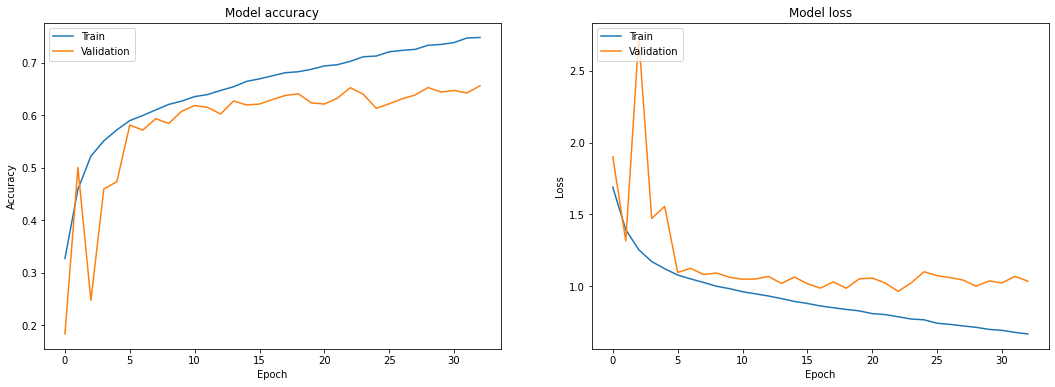

In [13]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Confusion matrix

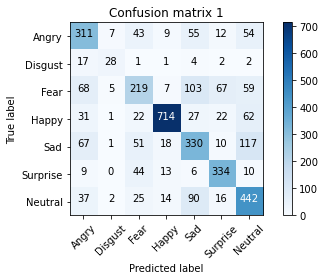

In [16]:
import itertools
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix 1'

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

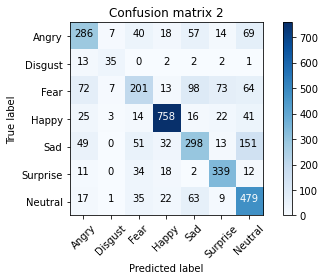

In [17]:
# Plot confusion matrix2
cm2 = confusion_matrix(y_test, y_pred2)
title2='Confusion matrix 2'

plt.imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title2)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm2.max() / 2.
for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
    plt.text(j, i, format(cm2[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm2[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Export the model

In [23]:
from keras.models import load_model
from keras.models import model_from_json

fer_json = model.to_json()
with open("CNN.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("CNN.h5")
print("Model saved (under \"CNN.h5\")")

Saved model to disk
